First:
- go to the terminal
- go to the `4_tuning_networks` folder, use `cd` to get there, or `z` to get there faster.
- if you are planning on closing the laptop to let this run by itself, start a tmux session by giving the command `tmux`. You can name the session with `ctrl+b $`, leave the tmux with `ctrl+b` d, access it again with `tmux a -t 0` or replace the 0 with the name you gave it. See [tmux](https://github.com/tmux/tmux/wiki/Getting-Started) for more info.
- Activate the `.venv`, and run `python hypertune.py`
- In the hypertune.py file, a tune_dir is specified: `models/ray`. We will check the contents of that folder after the hypertune finished. You can also use tensorboard to check the results. 
- this will take some time. I clocked 1901 seconds (30 minutes) on the VM

 0.0992908 |           119 |            3 |     26 |         576.744  |    0 |   0.942187

In [24]:
from pathlib import Path
tune_dir = Path("models/ray").resolve()
tune_dir.exists()

True

<font color='green'>

**Get the latest stored `ray` logs from the `hypertune.py` script. Following code will just sort the dirs in the in order to get the latest stored folder. The folders are stored with the timestamps, hence sorting will work in this way.**
</font>

In [25]:
tunelogs = [d for d in tune_dir.iterdir()]
tunelogs.sort()
latest = tunelogs[-1]
latest

PosixPath('/home/sarmad/Documents/code/upperkaam/notebooks_review/Deliverable_Part_1/notebooks/4_tuning_networks/models/ray/tune_model_2025-02-15_19-11-36')

<font color='green'>

**Let's initialize the ray to inspect the latest session.**
</font>

In [26]:
from ray.tune import ExperimentAnalysis
import ray


ray.init(ignore_reinit_error=True)
analysis = ExperimentAnalysis(latest)

2025-02-16 16:23:38,666	INFO worker.py:1672 -- Calling ray.init() again after it has already been called.


So, we find some info:

<font color='green'>

**The `results_df` holds all the experiments in Dataframe format which is easier to iterate to find the best model config.**
</font>

In [27]:
analysis.results_df.columns

Index(['valid_loss', 'train_loss', 'accuracy', 'timestamp',
       'checkpoint_dir_name', 'done', 'training_iteration', 'date',
       'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'experiment_tag',
       'config/input_size', 'config/output_size', 'config/dropout',
       'config/epochs', 'config/hidden_size', 'config/num_layers',
       'config/tune_dir'],
      dtype='object')

Let's focus on the parameters we wanted to tune.

<font color='green'>

**Code modified**
</font>

In [32]:
import plotly.express as px

plot = analysis.results_df
select = ["accuracy", "config/hidden_size", "config/dropout", "config/num_layers"]
p = plot[select].reset_index(drop=True).dropna()
p

,accuracy,config/hidden_size,config/dropout,config/num_layers
0,0.9609375,487.554296,0.374540,5
1,0.9765625,445.623368,0.058084,5
2,0.8671875,312.934608,0.731994,5
3,0.6484375,93.373282,0.156019,5
4,0.91875,367.203999,0.601115,5
5,0.059375,446.724520,0.971842,5
6,0.0359375,458.288484,1.000000,5
7,0.8296875,444.397683,0.749566,5
8,0.0421875,459.016460,0.997357,5
9,0.8265625,334.524597,0.667536,5


<font color='green'>

**In this `ray` session, we have in total of 18 experiments to search for the best parameters to increase the accuracy of the model. Hence, sorting with respect to accuracy will give the best performing model.**
</font>

<font color='green'>

**Code modified**
</font>

In [37]:
p.sort_values("accuracy", inplace=True)
p.reset_index(drop=True)


,accuracy,config/hidden_size,config/dropout,config/num_layers
0,0.0359375,458.288484,1.000000,5
1,0.0421875,459.016460,0.997357,5
2,0.059375,446.724520,0.971842,5
3,0.284375,486.749858,0.932541,5
4,0.334375,488.719956,0.908599,5
5,0.5625,484.873831,0.877504,5
6,0.6484375,93.373282,0.156019,5
7,0.728125,122.761984,0.032470,5
8,0.8265625,334.524597,0.667536,5
9,0.8296875,444.397683,0.749566,5


Make a parallel plot

<font color='green'>

**Code modified**
</font>

In [39]:
p["accuracy"] = p["accuracy"]*1
px.parallel_coordinates(p.reset_index(drop=True), color="accuracy")


<font color='green'>

**The above parallel plot shows the combination of all experiements present in the `ray` session. It shows that the best model contains high `hidden_size` value and less `dropout` value. The higher `dropout` value limits the model from learning as it drops most of the neurons in the iteration for weights calculation. For example, if the `dropout` value is 0.9, then for a single iteration 90% of the neurons doesn't learn anything, which reduces the overall accuacy. Hence, maintaining the right balance between `hidden_size` and `dropout` is the key to great performing model.**
</font>

<Axes: xlabel='config/hidden_size', ylabel='config/dropout'>

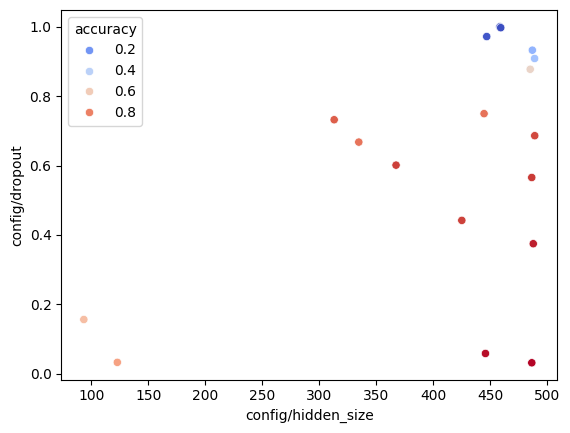

In [40]:
import seaborn as sns

sns.scatterplot(data=p, x="config/hidden_size", y="config/dropout", hue="accuracy", palette="coolwarm")

<font color='green'>

**The same phenomena can be observed from this scatterplot between `hidden_size` and `dropout` with respect to the `accuracy` of the model. It shows that the best model config should have `dropout` value around 0.1, and the `hidden_size` number should be around 512.**

**Note: these combinations are based on particular model configurations, we are just analyzing the combination between `hidden_szie` and `dropout` value for a given particular model.**
</font>


/tmp/ipykernel_1048314/81415808.py:4: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.



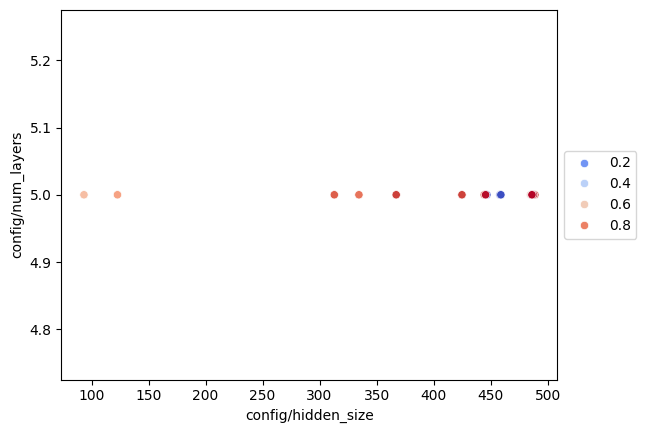

In [41]:
import matplotlib.pyplot as plt
cmap = sns.cubehelix_palette(as_cmap=True)
sns.scatterplot(data=p, x="config/hidden_size", y="config/num_layers", hue="accuracy", palette="coolwarm")
sns.kdeplot(data=p, x="config/hidden_size", y="config/num_layers", cmap=cmap)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

Get the best trial

<font color='green'>

**Code modified** from 'test_loss' to 'valid_loss'
</font>

In [13]:
analysis.get_best_trial(metric="valid_loss", mode="min")


tune_model_10278750

The top ten

In [14]:
p[-10:]


,trial_id,config/hidden_size,config/num_layers,accuracy
8,bff76491,459.016460,5,0.042188
9,4c6f04b2,334.524597,5,0.826563
10,7a588189,122.761984,5,0.728125
11,0c5e4989,424.886992,5,0.917188
12,10278750,486.258134,5,0.984375
13,1b04c256,488.719956,5,0.334375
14,bd748189,488.834327,5,0.90625
15,1aec31d7,486.223633,5,0.928125
16,59b1e0c1,484.873831,5,0.5625
17,1f35a54d,486.749858,5,0.284375


Or the best config

<font color='green'>

**Code modified** to get the best model config file
</font>

In [17]:
analysis.get_best_config(metric="valid_loss", mode="min")


{'input_size': 3,
 'output_size': 20,
 'dropout': 0.03125194395945996,
 'epochs': 5,
 'hidden_size': 486.25813435726695,
 'num_layers': 5,
 'tune_dir': PosixPath('/home/sarmad/Documents/code/upperkaam/notebooks_review/Deliverable_Part_1/notebooks/4_tuning_networks/models/ray')}

<font color='green'>

**The best model's config validates our analysis on previous plots. You can use the technique studied in the previous session to get the best combination of the model's parameters without training the model sperately for each combination.**
</font>
